# Chapter 6. Kernel Methods

## 6.4 Gaussian Processes

### 6.4.2 Gaussian processes for regression

In [1]:
library(abind)
generate_data <- function(func,sample_size,std,lowerbound=0, upperbound=1){
        x <- seq(lowerbound, upperbound, length.out = sample_size)
        #x <- sample(x)
        t <- func(x)+rnorm(sample_size,mean = 0, sd = std)
        result <- list("predictor_X"=x, "responser_t"=t)
        return(result)
}


sinusoidal <- function(x){
        y <- sin(2*pi*x)
        return(y)
}



trace <- function(A) {
        n <- dim(A)[1] 
        tr <- 0 
        for (k in 1:n) {
                l <- A[k,k]
                tr <- tr + l
        }
        return(tr[[1]])
}


# construct Radial basis kernel function
# k(x, y) = c0 * exp(-0.5 * c1 * (x1 - y1) ** 2 ...)
RBFkernel <- function(x, y, params){
        
        xmat = matrix(x, nrow=length(y), ncol=length(x), byrow = T)
        pairwise = xmat - y
        d.sum = sum(params[-1]) * pairwise^2
        kernel = params[1] * exp(-0.5 * d.sum)
        return(kernel)
}


RBFkernel.derivative <- function(x, y, params){
        
        xmat = matrix(x, nrow=length(y), ncol=length(x), byrow = T)
        pairwise = xmat - y
        
        d.sum = sum(params[-1]) * pairwise^2
        delta = exp(-0.5 * d.sum)
        deltas = -0.5 * pairwise^2 * (delta * params[1])
        result = list( "d1" = delta, "d2" = deltas )
        return(result)
        
}

GPR_loglikelihood <- function(covariance, precision, t){
        -0.5 * ( determinant(covariance)$modulus[1] + t %*% precision %*% t
                 + length(t) * log(2 * pi))
        # log(det(covariance))
        
}

# maximum likelihood estimation of parameters in kernel function
GPR_fit <- function(X, t, params, beta, iter_max=0, learning_rate=0.1){
        Gram = RBFkernel(X, X, params)
        I = diag(length(X))
        log_likelihood_list = -Inf
        covariance = Gram + I / beta
        precision = solve(covariance)
        for (i in 1:iter_max){
                #print(paste("i is", i))
                
                gradients = RBFkernel.derivative(X, X, params)
                
                # self.precision.dot(grad).dot(self.precision).dot(t)
                grad = gradients$d1
                updates1 = - trace(precision %*% grad) + 
                        t %*% ( precision %*% grad %*% precision %*% t )
                grad2 = gradients$d2
                updates2 = - trace(precision %*% grad2) + 
                        t %*% ( precision %*% grad2 %*% precision %*% t )
                
                updates = c(updates1, updates2)
                
                for (j in 1: iter_max){
                        params = params + learning_rate * updates
                        Gram = RBFkernel(X, X, params)
                        covariance = Gram + I / beta
                        precision = solve(covariance)
                        log_like = GPR_loglikelihood(covariance, precision, t)
                        if (log_like > tail(log_likelihood_list, n = 1)){
                                log_likelihood_list = c(log_likelihood_list,log_like)
                                break        
                        } else{
                                updates3 = -learning_rate * updates
                                params = params + updates3
                                learning_rate =learning_rate * 0.9
                        }
                }
                
        }
        log_likelihood_list = log_likelihood_list[-1]
        result = list("loglikelihood_list"= log_likelihood_list, 
                      "covariance "= covariance, "precision " = precision,
                      "params" = params)
        return(result)
}


# mean, std of the gaussian process
GPR_predict <- function(tstX, trnX, params, t, precision, beta, with_error = T) {
        
        K = RBFkernel(trnX, tstX, params)
        mean = K %*% precision %*% t
        if (with_error){
                var = params[1] + 1 /beta - rowSums(K %*% precision * K)
                std = sqrt(var)
                result = list("mean" = mean, "std" = std)
                return(result)
        } else{
                result = list("mean" = mean)
                return(result)
        }
}


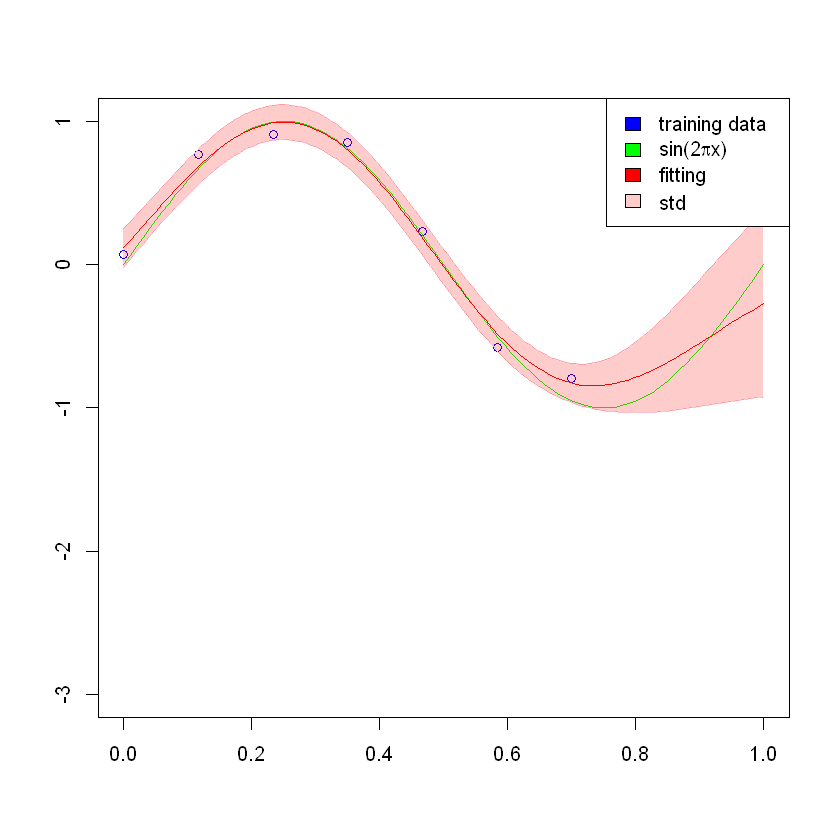

In [3]:
x = seq(0,1,length.out = 100)
x_train = generate_data(sinusoidal, sample_size=7, std=0.1,0,0.7)$predictor_X
y_train = generate_data(sinusoidal, sample_size=7, std=0.1,0,0.7)$responser_t
beta=100
fit1 =GPR_fit(x_train, y_train, params = c(1,1), beta=100, iter_max=200, learning_rate=0.1)
predict1 = GPR_predict(x, x_train, fit1$params, y_train, fit1$precision, beta, with_error = T)



plot(x_train, y_train,
     type="p", col="blue", xlab="", ylab="", xlim = c(0,1), ylim = c(-3,1))
lines(x, sinusoidal(x), col="green")
lines(x,predict1$mean, col="red")
lines(x,predict1$mean - predict1$std, col="pink")
lines(x,predict1$mean + predict1$std, col="pink")

y1 = predict1$mean - predict1$std
y2 = predict1$mean + predict1$std
polygon(c(x,rev(x)),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting","std"),
       fill=c("blue","green","red",rgb(1, 0, 0,0.2)))


### 6.4.3 Learning the hyperparameters

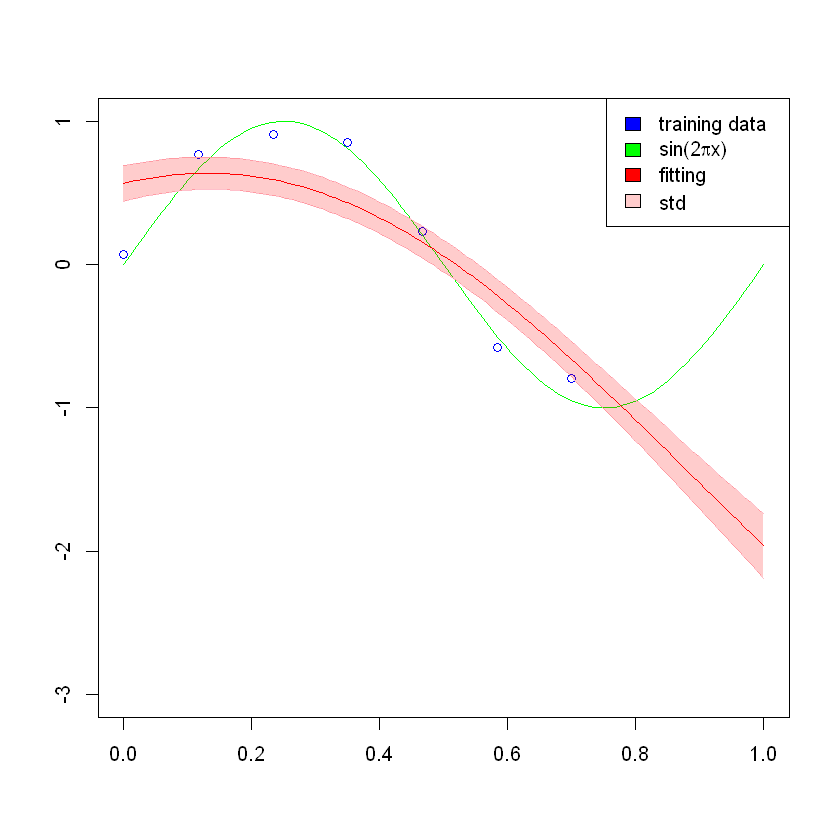

In [4]:
GPR_0iter <- function(X, t, params, beta, learning_rate=0.1){
        Gram = RBFkernel(X, X, params)
        I = diag(length(X))
        log_likelihood_list = -Inf
        covariance = Gram + I / beta
        precision = solve(covariance)
        log_likelihood_list = log_likelihood_list[-1]
        result = list("loglikelihood_list"= log_likelihood_list, 
                      "covariance "= covariance, "precision " = precision,
                      "params" = params)
        return(result)
}

fit1 =GPR_0iter(x_train, y_train, params = c(1,1), beta=100, learning_rate=0.1)
predict1 = GPR_predict(x, x_train, fit1$params, y_train, fit1$precision, beta, with_error = T)

plot(x_train, y_train,
     type="p", col="blue", xlab="", ylab="", xlim = c(0,1), ylim = c(-3,1))
lines(x, sinusoidal(x), col="green")
lines(x,predict1$mean, col="red")
lines(x,predict1$mean - predict1$std, col="pink")
lines(x,predict1$mean + predict1$std, col="pink")

y1 = predict1$mean - predict1$std
y2 = predict1$mean + predict1$std
polygon(c(x,rev(x)),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting","std"),
       fill=c("blue","green","red",rgb(1, 0, 0,0.2)))



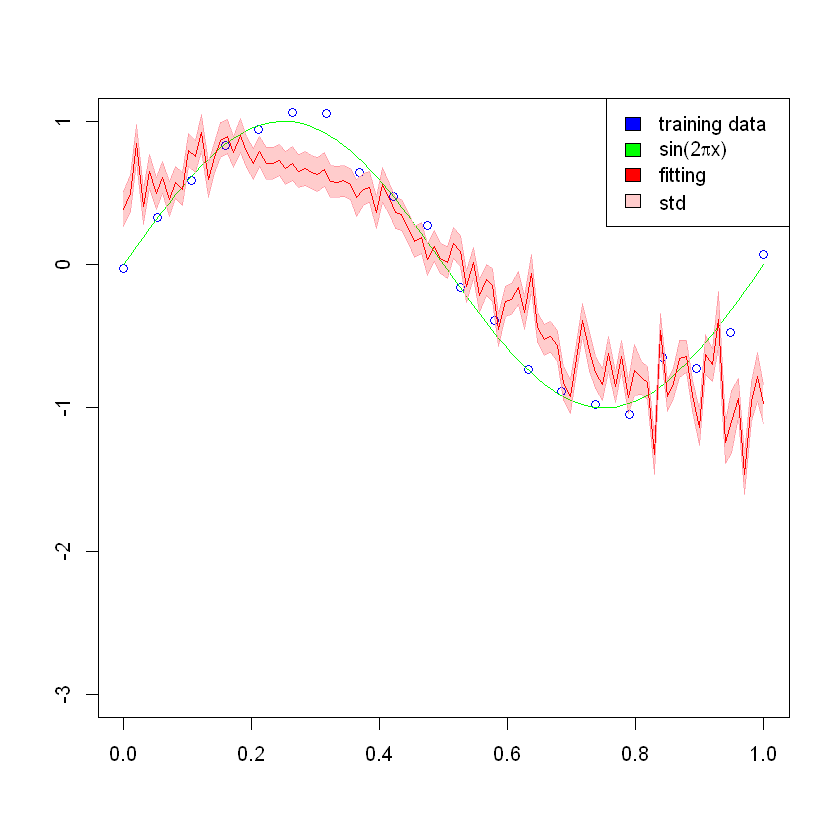

In [6]:


GPRfit_nd_0iter <- function(X, t, params, beta, iter_max=0, learning_rate=0.1){
        #beta: precision parameter of observation noise
        Gram = RBFkernel_nd(X, X, params)
        I = diag(nrow(X))
        log_likelihood_list = -Inf
        covariance = Gram + I / beta
        precision = solve(covariance)

        log_likelihood_list = log_likelihood_list[-1]
        result = list("loglikelihood_list"= log_likelihood_list, 
                      "covariance "= covariance, "precision " = precision,
                      "params" = params)
        return(result)
}

params=c(1,1,1,1)
fit1 =GPRfit_nd_0iter(x_train, y_train, params, beta, iter_max=100, learning_rate=0.001)
predict1 = GPR_predict_nd(x, x_train, fit1$params, y_train, 
                          fit1$precision, beta, with_error = T)

plot(x_train[,1], y_train,
     type="p", col="blue", xlab="", ylab="", xlim = c(0,1), ylim = c(-3,1))
lines(x[,1], sinusoidal(x[,1]), col="green")
lines(x[,1],predict1$mean, col="red")
lines(x[,1],predict1$mean - predict1$std, col="pink")
lines(x[,1],predict1$mean + predict1$std, col="pink")

y1 = predict1$mean - predict1$std
y2 = predict1$mean + predict1$std
polygon(c(x[,1],rev(x[,1])),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting","std"),
       fill=c("blue","green","red",rgb(1, 0, 0,0.2)))



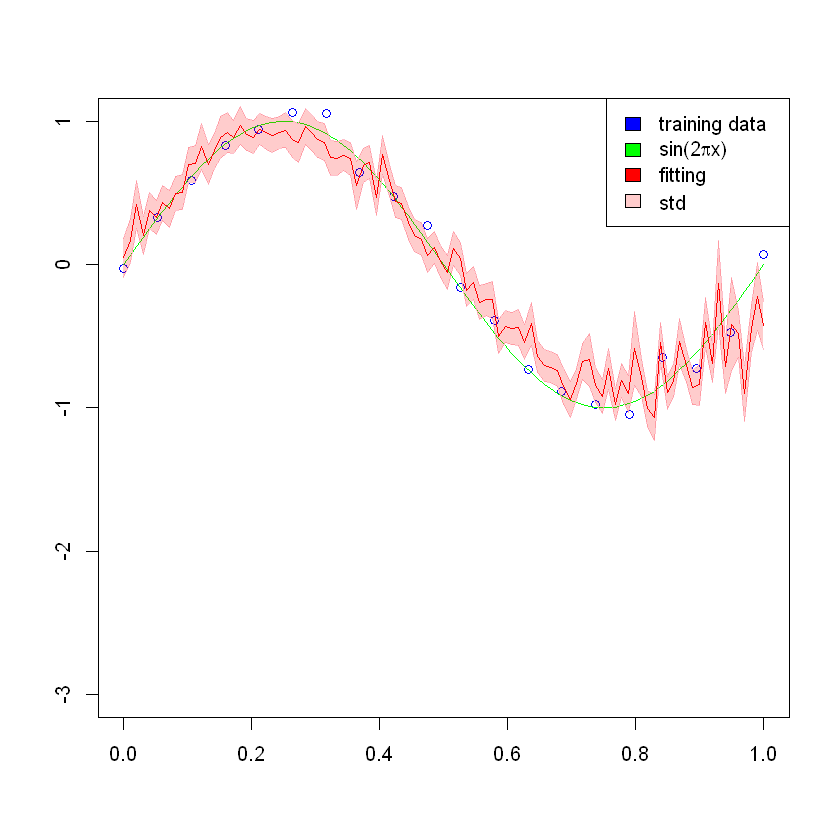

In [5]:
create_toy_data_3d <- function(func, n=10, std=1){
        x0 = seq(0, 1,length.out = n)
        x1 = x0 + rnorm(n,mean = 0, sd = std)
        x2 = rnorm(n,mean = 0, sd = std)
        t = func(x0) + rnorm(n,mean = 0, sd = std)
        x = matrix(c(x0, x1, x2), nrow = n)
        result <- list("predictor_X"=x, "responser_t"=t)
        return(result)
}



RBFkernel_nd <- function(x, y, params){
        
        x_arr = array(0,dim = c( nrow(y), ncol = ncol(x), nrow(x)))
        
        for (i in 1:nrow(x)){
                c= matrix(x[i,], nrow = nrow(y),ncol = ncol(x), byrow = T)
                x_arr[,,i] = c
        }
        y_arr = array(y,dim = c( nrow(y), ncol = ncol(y), nrow(x)))

        d = (x_arr - y_arr)^2
        q = matrix(params[-1],1)
        dp = sweep(d, 2, q,"*")

        dsum = matrix(0, nrow = nrow(x),ncol = nrow(y))
        for (j in 1:nrow(x)){
                dsum[j,] = rowSums(dp[,,j])       
        }
        return( params[1] * exp(-0.5 * dsum) )
}


RBFderivative_nd <- function(x, y, params){
        
        x_arr = array(0,dim = c( nrow(y), ncol = ncol(x), nrow(x)))
        r = array(0,dim = c( nrow(y), ncol = ncol(x), nrow(x)))
        
        for (i in 1:nrow(x)){
                c= matrix(x[i,], nrow = nrow(y),ncol = ncol(x), byrow = T)
                x_arr[,,i] = c
        }
        y_arr = array(y,dim = c( nrow(y), ncol = ncol(y), nrow(x)))
        
        d = (x_arr - y_arr)^2
        q = matrix(params[-1],1)
        dp = sweep(d, 2, q,"*")
        
        dsum = matrix(0, nrow = nrow(x),ncol = nrow(y))
        for (j in 1:nrow(x)){
                dsum[j,] = rowSums(dp[,,j])       
        }
        delta = exp(-0.5 * dsum)
        delta1 = delta * params[1] 
        
        for(i in 1:nrow(delta)){
                 r[,,i]= -0.5 * sweep(d[,,i], 1, matrix(delta1[i,]),"*")
                
        }
        deltas = aperm(r, c(1,3,2))
        result = abind(delta, deltas)
        return(result)
}


library(abind)

GPR_fit_nd <- function(X, t, params, beta, iter_max=0, learning_rate=0.1){
        #beta: precision parameter of observation noise
        Gram = RBFkernel_nd(X, X, params)
        I = diag(nrow(X))
        log_likelihood_list = -Inf
        covariance = Gram + I / beta
        precision = solve(covariance)

        for (i in 1:iter_max){
                #print(paste("i is", i))
                
                gradients = RBFderivative_nd(X, X, params)
                n = dim(gradients)[3]
                updates = rep(0,n)
                
                for (i in 1:n){
                        grad = gradients[,,i]
                        updates[i] = - trace(precision %*% grad) + 
                                t %*% ( precision %*% grad %*% precision %*% t )
                        #updates = c(updates,updates1)
                }
                
                for (j in 1: iter_max){
                        # print(paste("j is", j))
                        # learning_rate * updates
                        params = params + learning_rate * updates
                        Gram = RBFkernel_nd(X, X, params)
                        covariance = Gram + I / beta
                        precision = solve(covariance)
                        log_like = GPR_loglikelihood(covariance, precision, t)
                        if (log_like > tail(log_likelihood_list, n = 1)){
                                log_likelihood_list = c(log_likelihood_list,log_like)
                                #print(paste("list is", log_likelihood_list))
                                break        
                        } else{
                                updates3 = -learning_rate * updates
                                params = params + updates3
                                learning_rate =learning_rate * 0.9
                        }
                }
                
        }
        log_likelihood_list = log_likelihood_list[-1]
        result = list("loglikelihood_list"= log_likelihood_list, 
                      "covariance "= covariance, "precision " = precision,
                      "params" = params)
        return(result)
}

GPR_predict_nd <- function(tstX, trnX, params, t, precision, beta, with_error = T) {
        
        K = RBFkernel_nd(tstX, trnX,params)
        mean = K %*% precision %*% t
        if (with_error){
                var = params[1] + 1 /beta - rowSums(K %*% precision * K)
                std = sqrt(var)
                result = list("mean" = mean, "std" = std)
                return(result)
        } else{
                result = list("mean" = mean)
                return(result)
        }
}


# sinusoidal, n=20, std=0.1
x_train = create_toy_data_3d(sinusoidal, 20, 0.1)$predictor_X
y_train = create_toy_data_3d(sinusoidal, 20, 0.1)$responser_t

x0 = seq(0, 1,length.out = 100)
x1 = x0 + rnorm(100,mean = 0, sd = 0.1)
x2 = rnorm(100,mean = 0, sd = 0.1)
x = matrix(c(x0, x1, x2), nrow = 100)




params=c(1,1,1,1)
fit1 =GPR_fit_nd(x_train, y_train, params, beta, iter_max=100, learning_rate=0.001)
predict1 = GPR_predict_nd(x, x_train, fit1$params, y_train, 
                       fit1$precision, beta, with_error = T)

plot(x_train[,1], y_train,
     type="p", col="blue", xlab="", ylab="", xlim = c(0,1), ylim = c(-3,1))
lines(x[,1], sinusoidal(x[,1]), col="green")
lines(x[,1],predict1$mean, col="red")
lines(x[,1],predict1$mean - predict1$std, col="pink")
lines(x[,1],predict1$mean + predict1$std, col="pink")

y1 = predict1$mean - predict1$std
y2 = predict1$mean + predict1$std
polygon(c(x[,1],rev(x[,1])),c(y2,rev(y1)),col=rgb(1, 0, 0,0.2), border=NA)
legend("topright",
       c("training data",expression(paste("sin(2", pi, "x)")),"fitting","std"),
       fill=c("blue","green","red",rgb(1, 0, 0,0.2)))




### 6.4.5 Gaussian processes for classification

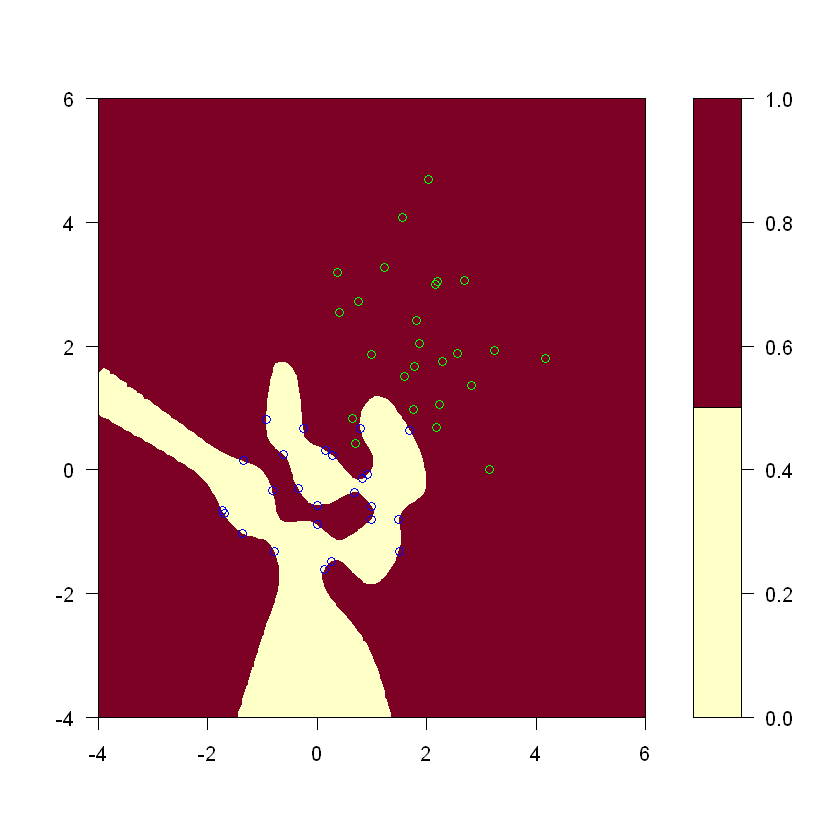

In [13]:

create_toy_data <- function(){
        x0 = matrix(rnorm(50), 25)
        x1 = matrix(rnorm(50)+2, 25)
        x2 = rbind(x0, x1)
        # matrix(c(rep(0,25), rep(1, 25)))
        y = c(rep(0,25), rep(1, 25))
        result = list("predictor" = x2, "reponser" = y)
        return(result) 
        
        
}

GPC_fit<- function(X, params, noise_level=1e-4){
        
        Gram = RBFkernel_nd(X, X, params)
        covariance = Gram + diag(nrow(Gram)) * noise_level
        precision = solve(covariance)
        result = list( "covariance "= covariance, "precision " = precision,
                      "params" = params)
        return(result)
}

GPC_predict <- function(tstX, trnX, params, t, precision){
        K = RBFkernel_nd(tstX, trnX,params)
        a_mean = K %*% precision %*% t
        result = tanh(a_mean * 0.5) * 0.5 + 0.5
        return(result)
}


x_train = create_toy_data()$predictor
y_train = create_toy_data()$reponser

x <- expand.grid(s.1 = seq(-4, 6, length.out=100), 
                 s.2 = seq(-4, 6, length.out=100))
x <-as.matrix(x)
params = c(1, 7, 7)


fit1 =GPC_fit(x_train, params = c(1, 7, 7), noise_level=1e-4)
predict1 = GPC_predict(x, x_train, fit1$params, y_train, 
                          fit1$precision)

predict1 = matrix(predict1, 100, 100)
filled.contour(x = seq(-4, 6, length.out=100), y = seq(-4, 6, length.out=100), 
               z = predict1, plot.title = title(main = ""),nlevels = 2,
               plot.axes = { axis(1); axis(2); points(x_train,col = ifelse(y_train == 1,'green','blue'))})




